In [7]:
#Añadir la raiz del proyecto temporal
import sys
sys.path.insert(0, "/home/ubuntu/projects/historical-analysis-management-tickets")

In [35]:
#dependencias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
import re
import glob
import os
import nltk
import time
from nltk.corpus import stopwords
import numpy as npa
from src.configuraciones import limpiar_texto
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
import joblib

In [22]:
#configuracion
plt.style.use('ggplot')

path = "/home/ubuntu/projects/historical-analysis-management-tickets/data/processed_SC"
all_files = glob.glob(os.path.join(path, "df*.csv"))

df_list = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    if 'fecha_de_apertura' in df.columns:
        df['fecha_de_apertura'] = pd.to_datetime(df['fecha_de_apertura'], errors='coerce', dayfirst=True)
    df_list.append(df)

df_all = pd.concat(df_list, axis=0, ignore_index=True)

/tmp/ipykernel_303429/4086124660.py:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['fecha_de_apertura'] = pd.to_datetime(df['fecha_de_apertura'], errors='coerce', dayfirst=True)


In [32]:
#asegurar categoria
if 'area' not in df_all.columns:
    df_all['area'] = df_all['categoria'].fillna('Sin Categoria').apply(lambda x: str(x).split('>')[0].strip())

df_labeled = df_all[df_all['area'] != 'Sin Categoria'].copy()

min_tickets = 20

#contamos clases
conteo_areas = df_labeled['area'].value_counts()
areas_validas = conteo_areas[conteo_areas > 50].index
df_labeled = df_labeled[df_labeled['area'].isin(areas_validas)]

print(f"Entrenando con {len(df_labeled)} tickets.")
print(f"Clases a predecir ({len(areas_validas)}): {list(areas_validas)}")

counts = df_labeled['area'].value_counts()
df_train = df_labeled[df_labeled['area'].isin(counts[counts > min_tickets].index)]

Entrenando con 102576 tickets.
Clases a predecir (22): ['DBA', 'Soporte de Campo', 'Aplicaciones', 'MDA', 'ABM', 'Ingenieros TI', 'OT', 'Técnico TI', 'Telecomunicaciones', 'Folios OT', 'Seguimientos IMA', 'Sistemas GIS', 'AMI', 'SAP', 'DTE', 'Telecomunicaciones Operacionales', 'Actividades Proyectos IMA', 'Desarrollo de Sistemas y Proyectos Tecnológicos', 'TDO', 'Ciberseguridad', 'Meridian', 'PowerOn']


In [ ]:
#limpieza de texto
nltk.download('stopwords')
stop_words = stopwords.words('spanish')

#data para XGBoost
le = LabelEncoder()
df_labeled['label_code'] = le.fit_transform(df_labeled['area'])
label_map = dict(zip(le.transform(le.classes_), le.classes_))
print("Clases detectadas:", list(label_map.values()))

#limpieza de texto
df_labeled["texto_limpio"] = df_labeled["titulo"].apply(limpiar_texto)

#variables
X = df_labeled['texto_limpio']
#y = df_labeled['area']
y = df_labeled['label_code']

#80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Clases detectadas: ['ABM', 'AMI', 'Actividades Proyectos IMA', 'Aplicaciones', 'Ciberseguridad', 'DBA', 'DTE', 'Desarrollo de Sistemas y Proyectos Tecnológicos', 'Folios OT', 'Ingenieros TI', 'MDA', 'Meridian', 'OT', 'PowerOn', 'SAP', 'Seguimientos IMA', 'Sistemas GIS', 'Soporte de Campo', 'TDO', 'Telecomunicaciones', 'Telecomunicaciones Operacionales', 'Técnico TI']



 inicio training de modelos
Naive Bayes: Acc=82.92% | F1=81.54% | 0.7s


/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression: Acc=82.48% | F1=84.44% | 12.8s
SVM (Linear): Acc=86.14% | F1=86.98% | 5.8s
Random Forest: Acc=86.84% | F1=86.84% | 63.1s
XGBoost: Acc=86.37% | F1=86.06% | 60.5s


/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM: Acc=76.55% | F1=77.03% | 35.0s
                Modelo  Accuracy  F1-Score  Tiempo (s)
2         SVM (Linear)  0.861376  0.869824    5.764042
3        Random Forest  0.868444  0.868399   63.139879
4              XGBoost  0.863667  0.860568   60.482039
1  Logistic Regression  0.824820  0.844436   12.757181
0          Naive Bayes  0.829158  0.815397    0.689208
5             LightGBM  0.765451  0.770346   34.959019


/tmp/ipykernel_303429/2878991524.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_res, x='F1-Score', y='Modelo', palette='viridis')


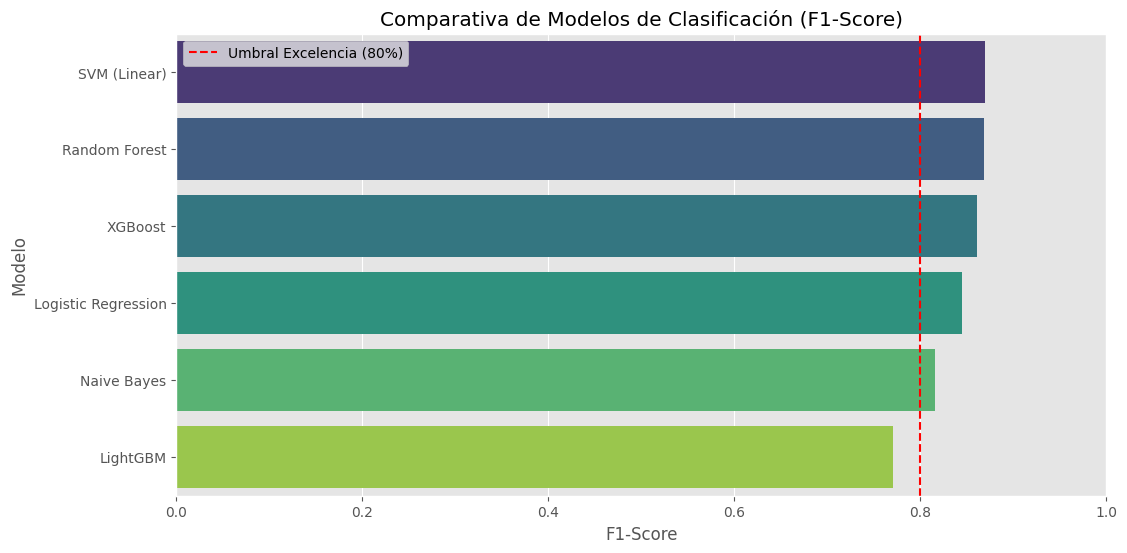


 Analizando a fondo al ganador: SVM (Linear)
                                                 precision    recall  f1-score   support

                                            ABM       0.75      0.79      0.77      1499
                                            AMI       0.60      0.86      0.70        65
                      Actividades Proyectos IMA       0.41      0.61      0.49        36
                                   Aplicaciones       0.90      0.84      0.87      3429
                                 Ciberseguridad       0.19      0.50      0.27        16
                                            DBA       0.97      0.92      0.94      5577
                                            DTE       0.46      0.66      0.54        53
Desarrollo de Sistemas y Proyectos Tecnológicos       0.05      0.20      0.08        35
                                      Folios OT       0.99      0.99      0.99       143
                                  Ingenieros TI       0.69     

In [ ]:

modelos = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', MultinomialNB())
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1))
    ]),
    'SVM (Linear)': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', LinearSVC(class_weight='balanced', random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42, eval_metric='mlogloss'))
    ]),
    'LightGBM': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbose=-1))
    ])
}

#train
resultados = []

print("\n inicio training de modelos")
for nombre, pipe in modelos.items():
    inicio = time.time()
    try:
        # Entrenar
        pipe.fit(X_train, y_train)
        
        # Predecir
        y_pred = pipe.predict(X_test)
        
        # Métricas
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted') # Weighted por el desbalance de clases
        
        tiempo = time.time() - inicio
        resultados.append({'Modelo': nombre, 'Accuracy': acc, 'F1-Score': f1, 'Tiempo (s)': tiempo})
        print(f"{nombre}: Acc={acc:.2%} | F1={f1:.2%} | {tiempo:.1f}s")
        
    except Exception as e:
        print(f"Error en {nombre}: {e}")

# tabla de posiciones
df_res = pd.DataFrame(resultados).sort_values('F1-Score', ascending=False)
print(df_res)

# Visualización
plt.figure(figsize=(12, 6))
sns.barplot(data=df_res, x='F1-Score', y='Modelo', palette='viridis')
plt.title('Comparativa de Modelos de Clasificación (F1-Score)')
plt.xlim(0, 1.0)
plt.axvline(0.8, color='red', linestyle='--', label='Umbral Excelencia (80%)')
plt.legend()
plt.show()

# analisis del mejor modelo
mejor_modelo_nombre = df_res.iloc[0]['Modelo']
mejor_pipeline = modelos[mejor_modelo_nombre]

print(f"\n Analizando a fondo al ganador: {mejor_modelo_nombre}")
y_pred_final = mejor_pipeline.predict(X_test)

# Reporte por Clase (Recuperando nombres reales con label_map)
print(classification_report(y_test, y_pred_final, target_names=list(label_map.values())))


--- Detalle por Área (Random Forest) ---
                                                 precision    recall  f1-score   support

                                            ABM       0.78      0.79      0.79      1499
                                            AMI       0.76      0.72      0.74        65
                      Actividades Proyectos IMA       0.88      0.64      0.74        36
                                   Aplicaciones       0.84      0.89      0.86      3429
                                 Ciberseguridad       0.12      0.12      0.12        16
                                            DBA       0.95      0.93      0.94      5577
                                            DTE       0.60      0.66      0.63        53
Desarrollo de Sistemas y Proyectos Tecnológicos       0.08      0.14      0.10        35
                                      Folios OT       0.97      0.99      0.98       143
                                  Ingenieros TI       0.75      0.6

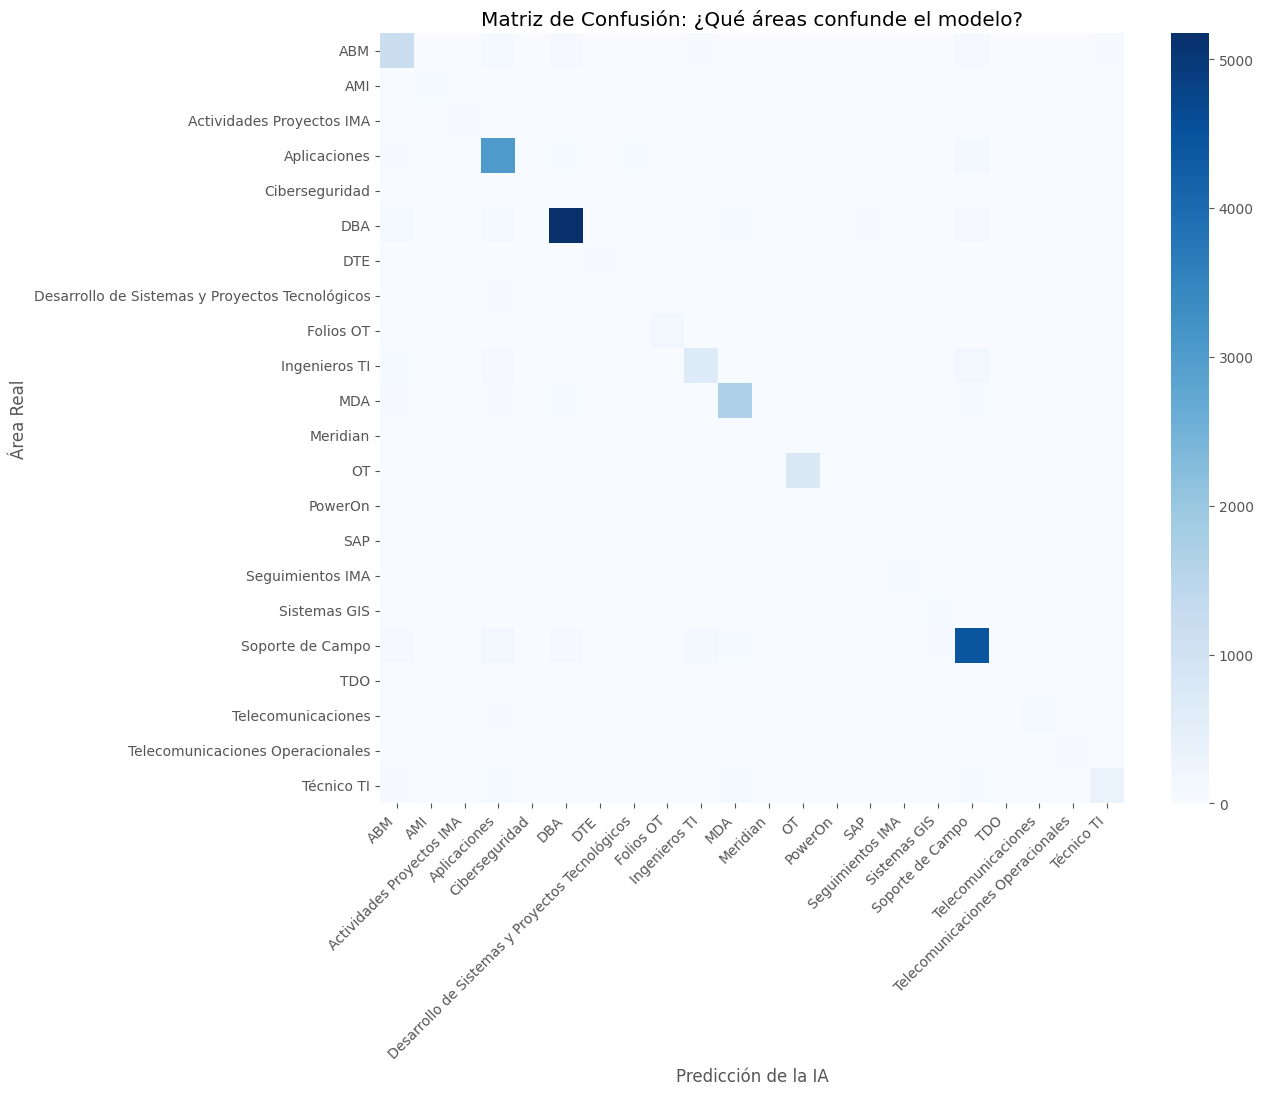

In [ ]:
# Seleccionamos el mejor (ajusta el nombre según el resultado anterior)
best_model_name = resultados.iloc[0]['Modelo']
best_model = modelos[best_model_name]

y_pred_final = best_model.predict(X_test)

# A. Reporte de Clasificación (Precision, Recall, F1)
print(f"\n--- Detalle por Área ({best_model_name}) ---")
print(classification_report(y_test, y_pred_final))

# B. Matriz de Confusión Visual
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_final, labels=best_model.classes_)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title(f'Matriz de Confusión: ¿Qué áreas confunde el modelo?')
plt.xlabel('Predicción de la IA')
plt.ylabel('Área Real')
plt.xticks(rotation=45, ha='right')
plt.show()

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Entrenando con 102576 tickets.
Clases detectadas: ['ABM', 'AMI', 'Actividades Proyectos IMA', 'Aplicaciones', 'Ciberseguridad', 'DBA', 'DTE', 'Desarrollo de Sistemas y Proyectos Tecnológicos', 'Folios OT', 'Ingenieros TI', 'MDA', 'Meridian', 'OT', 'PowerOn', 'SAP', 'Seguimientos IMA', 'Sistemas GIS', 'Soporte de Campo', 'TDO', 'Telecomunicaciones', 'Telecomunicaciones Operacionales', 'Técnico TI']

--- APLICANDO BALANCEO DE CLASES (TRAIN SET) ---
Dataset Train aumentado: 82060 -> 83459

--- INICIO TRAINING DE MODELOS ---
✅ Naive Bayes: Acc=83.10% | F1=81.87% | 0.7s


/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


✅ Logistic Regression: Acc=82.66% | F1=84.55% | 14.0s
✅ SVM (Calibrated): Acc=87.68% | F1=87.39% | 15.6s
✅ Random Forest: Acc=86.58% | F1=86.66% | 64.8s
✅ XGBoost: Acc=86.22% | F1=85.96% | 61.3s

🏆 TABLA DE RESULTADOS:
                Modelo  Accuracy  F1-Score  Tiempo (s)
2     SVM (Calibrated)  0.876779  0.873924   15.581923
3        Random Forest  0.865812  0.866632   64.830199
4              XGBoost  0.862156  0.859561   61.292606
1  Logistic Regression  0.826574  0.845470   14.028556
0          Naive Bayes  0.831010  0.818675    0.709792

🔎 Analizando al ganador: SVM (Calibrated)
                                                 precision    recall  f1-score   support

                                            ABM       0.78      0.80      0.79      1499
                                            AMI       0.80      0.78      0.79        65
                      Actividades Proyectos IMA       0.68      0.47      0.56        36
                                   Aplicaciones    

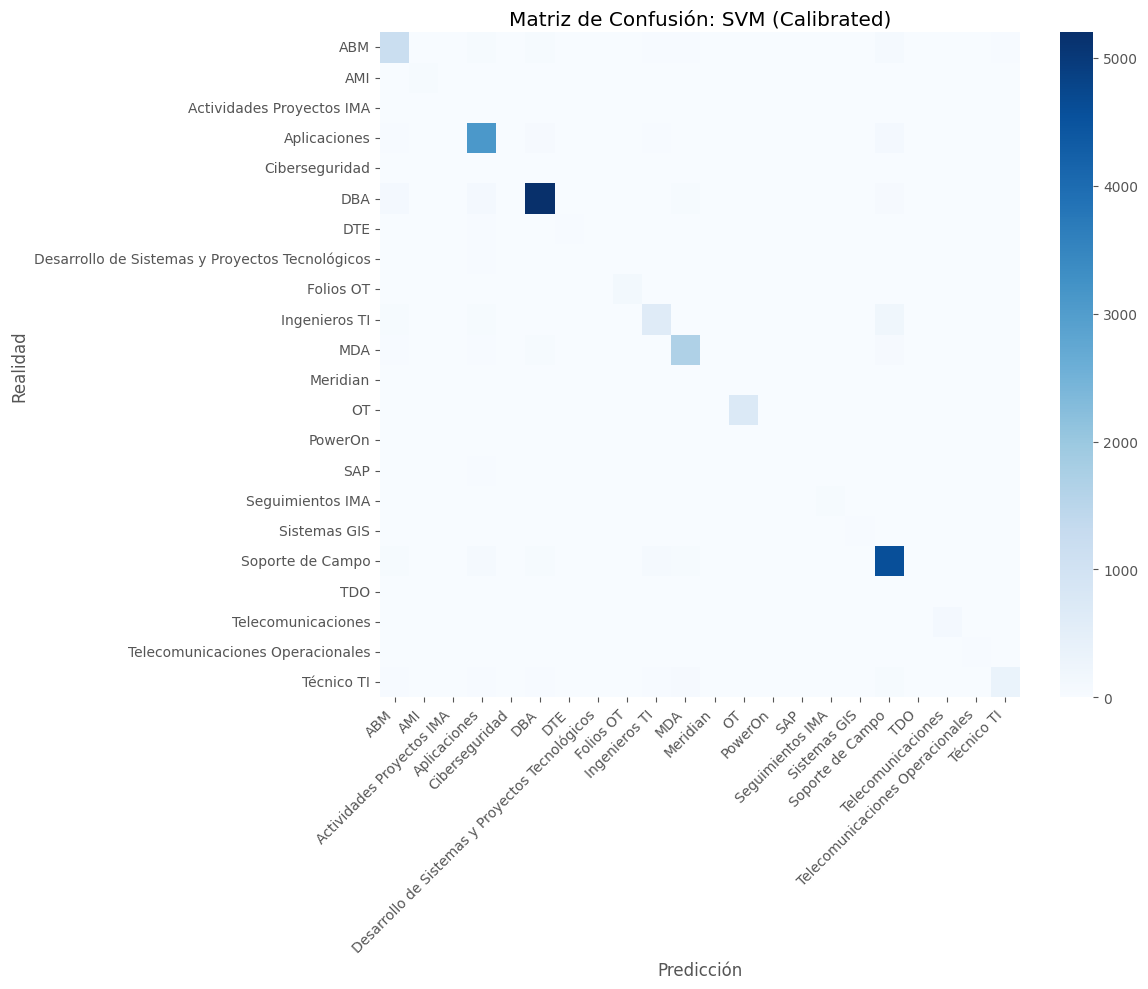

In [ ]:
# Reconstruimos un DF temporal solo con train
df_train_temp = pd.DataFrame({'texto': X_train, 'label': y_train})
conteo_train = df_train_temp['label'].value_counts()
minimo_deseado = 300 # Umbral para inflar clases chicas

dfs_extra = []
for label_code, count in conteo_train.items():
    if count < minimo_deseado:
        # Calculamos multiplicador
        multiplicador = int(round(minimo_deseado / count))
        if multiplicador > 1:
            df_subset = df_train_temp[df_train_temp['label'] == label_code]
            # Duplicamos
            dfs_extra.append(pd.concat([df_subset] * (multiplicador - 1)))
            # print(f"   -> Clase {label_map[label_code]} aumentada x{multiplicador}")

if dfs_extra:
    df_train_bal = pd.concat([df_train_temp] + dfs_extra).sample(frac=1, random_state=42)
    X_train_bal = df_train_bal['texto']
    y_train_bal = df_train_bal['label']
    print(f"Dataset Train aumentado: {len(X_train)} -> {len(X_train_bal)}")
else:
    X_train_bal, y_train_bal = X_train, y_train

# --- 3. MODELOS (CON ESTRATEGIA C: CALIBRACIÓN) ---
modelos = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', MultinomialNB())
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1))
    ]),
    # AQUI ESTA EL CAMBIO CLAVE PARA SVM: CalibratedClassifierCV
    'SVM (Calibrated)': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', CalibratedClassifierCV(
            LinearSVC(class_weight='balanced', random_state=42, dual='auto'),
            method='sigmoid', cv=3)
        )
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42, eval_metric='mlogloss'))
    ])
}

# train
resultados = []

print("\n--- INICIO TRAINING DE MODELOS ---")
for nombre, pipe in modelos.items():
    inicio = time.time()
    try:
        # datos balanceados
        pipe.fit(X_train_bal, y_train_bal)
        
        # Predecir
        y_pred = pipe.predict(X_test)
        
        # Métricas
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        tiempo = time.time() - inicio
        resultados.append({'Modelo': nombre, 'Accuracy': acc, 'F1-Score': f1, 'Tiempo (s)': tiempo})
        print(f"✅ {nombre}: Acc={acc:.2%} | F1={f1:.2%} | {tiempo:.1f}s")
        
    except Exception as e:
        print(f"Error en {nombre}: {e}")

# Tabla de posiciones
df_res = pd.DataFrame(resultados).sort_values('F1-Score', ascending=False)
print("\nTABLA DE RESULTADOS:")
print(df_res)

# Analisi del mejor modelo
mejor_modelo_nombre = df_res.iloc[0]['Modelo']
mejor_pipeline = modelos[mejor_modelo_nombre]

print(f"\nAnalizando al ganador: {mejor_modelo_nombre}")

# probabilidades
probs = mejor_pipeline.predict_proba(X_test)
max_probs = np.max(probs, axis=1) 
y_pred_indices = np.argmax(probs, axis=1) 
y_pred_final = mejor_pipeline.classes_[y_pred_indices]

# Reporte
print(classification_report(y_test, y_pred_final, target_names=list(label_map.values())))

#umbral de calidad
UMBRAL = 0.70 
print(f"\nSIMULACIÓN (Umbral {UMBRAL*100}%)")

y_test_array = np.array(y_test)
mask_auto = max_probs >= UMBRAL 

# Métricas Operativas
total_tickets = len(y_test)
auto_tickets = np.sum(mask_auto)
manual_tickets = total_tickets - auto_tickets

# Accuracy en los que si asignamos
if auto_tickets > 0:
    acc_operativo = accuracy_score(y_test_array[mask_auto], y_pred_final[mask_auto])
else:
    acc_operativo = 0

print(f"1. Cobertura Automática: {auto_tickets/total_tickets:.1%} ({auto_tickets} tickets)")
print(f"2. Precisión en Automático: {acc_operativo:.2%} (Esta es la fiabilidad real)")
print(f"3. Enviados a Manual: {manual_tickets/total_tickets:.1%} ({manual_tickets} tickets)")

# matriz de confusion
plt.figure(figsize=(12, 10))
nombres_clases = list(label_map.values())
cm = confusion_matrix(y_test, y_pred_final)

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=nombres_clases, yticklabels=nombres_clases)
plt.title(f'Matriz de Confusión: {mejor_modelo_nombre}')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
#guardar modelo
os.makedirs('../models', exist_ok=True)
path_modelo = '../models/SVM_best.pkl'
joblib.dump(mejor_pipeline, path_modelo)
print(f"Modelo guardado exitosamente en: {path_modelo}")

Modelo guardado exitosamente en: ../models/SVM_best.pkl
